# imports

In [1]:
import sys
import os
import h5py
import mattplotlib

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
import pickle
from copy import deepcopy

# plotting
import seaborn as sns
import seaborn_image as isns
import matplotlib.pyplot as plt
import mattplotlib as mplt
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Invoking __init__.py for NDNT.utils
Running on Computer: [beast]
Save_dir = ./Monocular/


In [13]:
# create ADAM params
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

# load data

Loading expt04
  Time embedding...
11 cells, 362504 time steps.


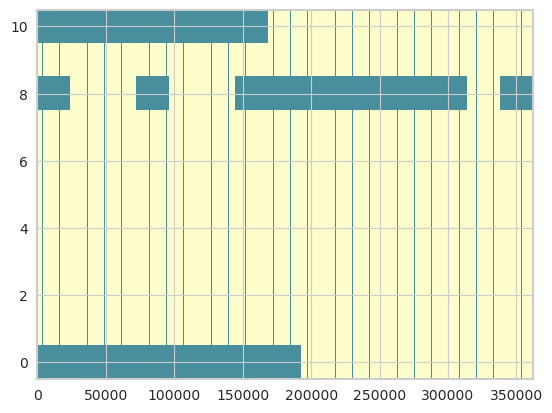

In [14]:
# load data
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

# three layer network

---> 1


NDN(
  (loss_module): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (loss): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (val_loss): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (networks): ModuleList(
    (0): FFnetwork(
      (layers): ModuleList(
        (0): NDNLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
      )
    )
    (1): FFnetwork(
      (layers): ModuleList(
        (0): NDNLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
        (1): NDNLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
      )
    )
    (2): FFnetwork(
      (layers): ModuleList(
        (0): NDNLayer(
          (NL): ReLU()
          (reg): Regula

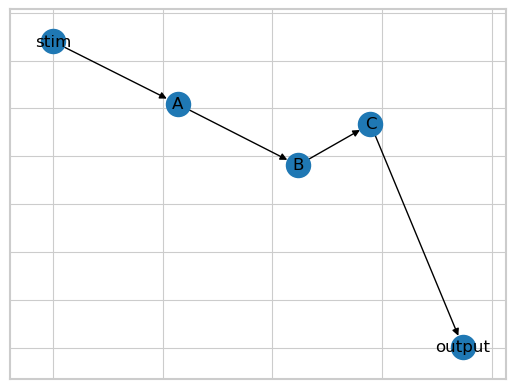

In [34]:
import model_factory as mf
import model as m

netAlayer0 = m.Layer(
    norm_type=m.Norm.none,
    NLtype=m.NL.relu,
    bias=False,
    initialize_center=True,
    reg_vals={'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}},
    num_filters=3
)
netBlayer0 = m.Layer(
    norm_type=m.Norm.none,
    NLtype=m.NL.relu,
    bias=False,
    initialize_center=True,
    reg_vals={'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}},
    num_filters=4
)
netBlayer1 = m.Layer(
    norm_type=m.Norm.none,
    NLtype=m.NL.relu,
    bias=False,
    initialize_center=True,
    reg_vals={'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}},
    num_filters=5
)
netClayer0 = m.Layer(
    norm_type=m.Norm.none,
    NLtype=m.NL.relu,
    bias=False,
    initialize_center=True,
    reg_vals={'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}
)

inp_stim = m.Input(covariate='stim', input_dims=data.stim_dims)
netA = m.Network(layers=[netAlayer0], name='A')
netB = m.Network(layers=[netBlayer0, netBlayer1], name='B')
netC = m.Network(layers=[netClayer0], name='C')
output_11 = m.Output(num_neurons=data.NC)

inp_stim.to(netA)
netA.to(netB)
netB.to(netC)
netC.to(output_11)
model = m.Model(output_11)

created_models = mf.create_models(model, verbose=False)

created_models[0].draw_network()

created_models[0].NDN

In [35]:
created_models[0].NDN.fit(data, **adam_pars)


GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.6397383213043213 sec elapsed


# 1-layer conv network

Created 4


NDN(
  (loss_module): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (loss): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (val_loss): PoissonLoss_datafilter(
    (loss): PoissonNLLLoss()
    (lossNR): PoissonNLLLoss()
  )
  (networks): ModuleList(
    (0): FFnetwork(
      (layers): ModuleList(
        (0): ConvLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
        (1): ConvLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
        (2): NDNLayer(
          (NL): ReLU()
          (reg): Regularization(
            (reg_modules): ModuleList()
          )
        )
      )
    )
  )
)

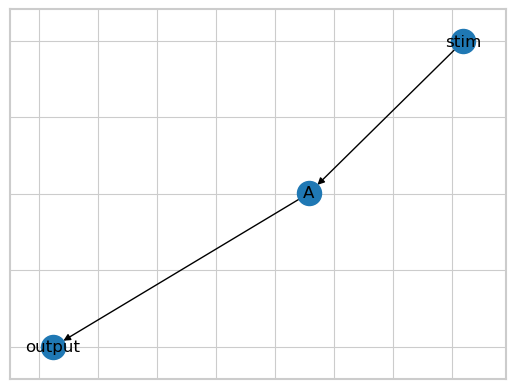

In [83]:
import model_factory as mf
import model as m


netAlayer0 = m.ConvolutionalLayer(
    norm_type=m.Norm.none,
    NLtype=m.NL.relu,
    bias=False,
    initialize_center=True,
    reg_vals=[{'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}, {'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}],
    num_filters=8,
    filter_dims=21,
    window='hamming'
)
netAlayer1 = m.ConvolutionalLayer(
    norm_type=m.Norm.none,
    NLtype=m.NL.relu,
    bias=False,
    initialize_center=True,
    reg_vals={'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}},
    num_filters=4,
    filter_dims=21,
    window='hamming'
)
netAlayer2 = m.Layer(
    norm_type=m.Norm.none,
    NLtype=m.NL.relu,
    bias=False,
    initialize_center=True,
    reg_vals=[{'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}, {'l1':0.1, 'localx':0.001, 'bcs':{'d2xt':1}}],
)

inp_stim = m.Input(covariate='stim', input_dims=data.stim_dims)
netA = m.Network(layers=[netAlayer0, netAlayer1, netAlayer2], name='A')
output_11 = m.Output(num_neurons=data.NC)

inp_stim.to(netA)
netA.to(output_11)
model = m.Model(output_11)

created_models = mf.create_models(model, verbose=False)
print('Created', len(created_models))

created_models[0].draw_network()

created_models[0].NDN

In [37]:
created_models[0].NDN.fit(data, **adam_pars)


GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.2039363384246826 sec elapsed


# scaffold network

In [38]:
num_subs = [8, 8, 4]
fws = [21, 9, 9]
XTregB = 0.0001
Greg = 0.001
Creg= None
clayers = []
for ii in range(0,len(num_subs)):
    clayers.append(
        ConvLayer.layer_dict(
            num_filters=num_subs[ii], bias=False, norm_type=1, num_inh=num_subs[ii]//2,
            filter_dims=fws[ii], padding='same', NLtype='relu', initialize_center = True) )
    clayers[ii]['output_norm'] = 'batch'
    clayers[ii]['window'] = 'hamming'
clayers[0]['input_dims'] = data.stim_dims
clayers[0]['reg_vals'] = {'d2xt': XTregB, 'center': Creg, 'bcs':{'d2xt':1} }

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold',
    xstim_n = 'stim', layer_list = clayers )

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, norm_type=0,
    NLtype='softplus', bias=True,
    pos_constraint=True,
    initialize_center = True)
readout_par['reg_vals'] = {'glocalx': Greg  }

readout_net = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_par], ffnet_type='normal')

cnn = NDN.NDN( ffnet_list=[scaffold_net, readout_net] )
cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([72, 8])
  Layer 2:
      weight: torch.Size([72, 4])
Network 1:
  Layer 0:
      weight: torch.Size([720, 11])
      bias: torch.Size([11])


In [89]:
import model_factory as mf
import model as m

conv_layer0 = m.ConvolutionalLayer(
    norm_type=m.Norm.none,
    NLtype=m.NL.relu,
    bias=False,
    initialize_center=True,
    reg_vals={'d2xt': 0.0001, 'center': None, 'bcs':{'d2xt':1} },
    num_filters=8,
    filter_dims=21,
    window='hamming',
    output_norm='batch',
    num_inh=4
)
conv_layer1 = m.ConvolutionalLayer().like(conv_layer0)
conv_layer1.params['num_filters'] = [8]
conv_layer1.params['num_inh'] = [4]
conv_layer1.params['filter_dims'] = [9]
conv_layer2 = m.ConvolutionalLayer().like(conv_layer0)
conv_layer2.params['num_filters'] = [4]
conv_layer2.params['num_inh'] = [2]
conv_layer2.params['filter_dims'] = [9]

readout_layer0 = m.Layer(
    norm_type=m.Norm.none,
    NLtype=m.NL.softplus,
    bias=True,
    reg_vals={'glocalx': 0.001},
    pos_constraint=True
)

inp_stim = m.Input(covariate='stim', input_dims=data.stim_dims)

scaffold_net = m.Network(layers=[conv_layer0, conv_layer1, conv_layer2], 
                         network_type=m.NetworkType.scaffold, 
                         name='scaffold')
readout_net = m.Network(layers=[readout_layer0], 
                        name='readout')
output_11 = m.Output(num_neurons=data.NC)

inp_stim.to(scaffold_net)
scaffold_net.to(readout_net)
readout_net.to(output_11)
model = m.Model(output_11)

created_models = mf.create_models(model, verbose=False)
print(len(created_models))

1


In [90]:
created_models[0].NDN.fit(data, **adam_pars)


GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.3975613117218018 sec elapsed


# hyperparameter optimization on a scaffold network

created 8 models


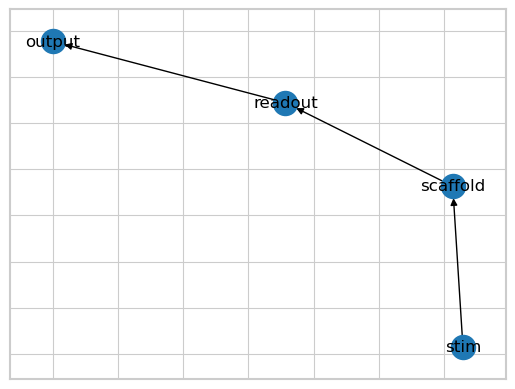

In [15]:
import experiment as exp
import model_factory as mf
import model as m
reload(exp)

conv_layer0 = m.ConvolutionalLayer(
    norm_type=m.Norm.none,
    NLtype=m.NL.relu,
    bias=False,
    initialize_center=True,
    reg_vals=[
        {'d2xt': 0.0001, 'center': None, 'bcs':{'d2xt':1} },
        {'d2xt': 0.001, 'center': None, 'bcs':{'d2xt':1} }
    ],
    num_filters=8,
    filter_dims=21,
    window='hamming',
    output_norm='batch',
    num_inh=4
)
conv_layer1 = m.ConvolutionalLayer().like(conv_layer0)
conv_layer1.params['num_filters'] = [8]
conv_layer1.params['num_inh'] = [4]
conv_layer1.params['filter_dims'] = [9]
conv_layer2 = m.ConvolutionalLayer().like(conv_layer0)
conv_layer2.params['num_filters'] = [4]
conv_layer2.params['num_inh'] = [2]
conv_layer2.params['filter_dims'] = [9]

readout_layer0 = m.Layer(
    norm_type=m.Norm.none,
    NLtype=m.NL.softplus,
    bias=True,
    reg_vals=[
        {'glocalx': 0.001}],
    pos_constraint=True
)

inp_stim = m.Input(covariate='stim', input_dims=data.stim_dims)

scaffold_net = m.Network(layers=[conv_layer0, conv_layer1, conv_layer2],
                         network_type=m.NetworkType.scaffold,
                         name='scaffold')
readout_net = m.Network(layers=[readout_layer0],
                        name='readout')
output_11 = m.Output(num_neurons=data.NC)

inp_stim.to(scaffold_net)
scaffold_net.to(readout_net)
readout_net.to(output_11)
model_template = m.Model(output_11)

created_models = mf.create_models(model_template, verbose=False)
print('created', len(created_models), 'models')
created_models[0].draw_network()

In [25]:
exp_regvals = exp.Experiment('reg_vals', model_template, data, adam_pars, overwrite=True)
exp_regvals.exparams['data']

[autoreload of experiment failed: Traceback (most recent call last):
  File "/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    update_instances(old, new)
  File "/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]


In [26]:
exp_regvals.run()

Creating models
Created 8 models


8it [00:00, 24690.53it/s]


==== Running 8 trials ====
==== Trial 0 --> m0d0f0 ====

GPU Available: True, GPU Used: True
Epoch 1: train loss 1028.7728 val loss 1004.2897
Done fitting
  Fit complete: 29.194865942001343 sec elapsed


AttributeError: 'Model' object has no attribute 'eval_models'

# make sure I can still define expression trees

output --> None
Output Output name=output, num_neurons=11
n6 --> output
Network Network name=n6 7, len(layers)=1, inputs=
n5 --> n6
Network Network name=n5 6, len(layers)=1, inputs=
n3+n4 --> n5
Add Add name=+ 5
n3 --> +
Network Network name=n3 4, len(layers)=1, inputs=
n1+n2 --> n3
Add Add name=+ 3
n1 --> +
Network Network name=n1 2, len(layers)=1, inputs=
i1 --> n1
Input Input name=i1, covariate=i1, input_dims=1,36,1,10
n2 --> +
Network Network name=n2 1, len(layers)=1, inputs=
i2 --> n2
Input Input name=i2, covariate=i2, input_dims=1,36,1,10
n4 --> +
Network Network name=n4 0, len(layers)=1, inputs=
i3 --> n4
Input Input name=i3, covariate=i3, input_dims=1,36,1,10
====FF====
--- n4 ---
{'ffnet_n': None,
 'ffnet_type': 'normal',
 'layer_list': [{'NLtype': 'softplus',
                 'bias': False,
                 'bias_initializer': 'zeros',
                 'initialize_center': False,
                 'input_dims': [1, 36, 1, 10],
                 'layer_type': 'normal',
         

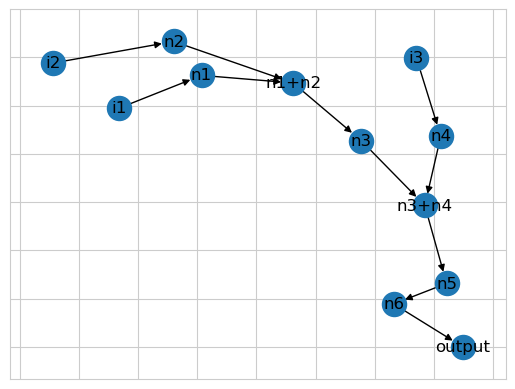

In [47]:
import model as m
from importlib import reload
import model_factory as mf
reload(m)
reload(mf)

l1 = m.Layer(num_filters=8, NLtype=m.NL.relu)
l2 = m.Layer(num_filters=8, NLtype=m.NL.relu)
l3 = m.Layer(num_filters=4, NLtype=m.NL.softplus)
l4 = m.Layer(num_filters=4, NLtype=m.NL.softplus)
l5 = m.Layer(num_filters=[6,8], NLtype=m.NL.relu)
l6 = m.Layer(NLtype=m.NL.relu, bias=True)

i1 = m.Input(covariate='i1', input_dims=[1,36,1,10])
i2 = m.Input(covariate='i2', input_dims=[1,36,1,10])
i3 = m.Input(covariate='i3', input_dims=[1,36,1,10])
n1 = m.Network(layers=[l1], name='n1')
n2 = m.Network(layers=[l2], name='n2')
n3 = m.Network(layers=[l3], name='n3')
n4 = m.Network(layers=[l4], name='n4')
n5 = m.Network(layers=[l5], name='n5')
n6 = m.Network(layers=[l6], name='n6')
o  = m.Output(11)

i1.to(n1)
i2.to(n2)
i3.to(n4)
m.Add(networks=[n1,n2]).to(n3)
m.Add(networks=[n3,n4]).to(n5)
n5.to(n6)
n6.to(o)

m1 = m.Model(o)
m1.draw_network()
m2 = mf.create_models(m1, verbose=True)

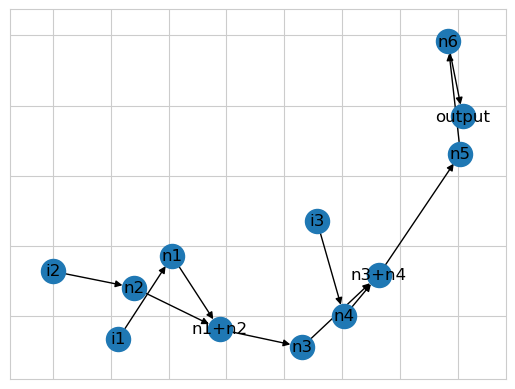

In [48]:
m2[0].draw_network()